In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib as mpl
import BiGLasso_Methods as bg
import GmGM
import scipy.stats as stats
import scipy.sparse as sparse
import igraph as ig
import mean_wrapper as mw

import os

In [2]:
# Load data
# Get all types of objects
data_dir = 'data/coil-20-proc/'
headers = {x.split('__')[0] for x in os.listdir(data_dir)}
print(headers)

{'obj9', 'obj12', 'obj7', 'obj5', 'obj20', 'obj16', 'obj4', 'obj10', 'obj17', 'obj19', 'obj13', 'obj6', 'obj15', 'obj8', 'obj3', 'obj2', 'obj14', 'obj18', 'obj11', 'obj1'}


In [3]:
# Every object has 72 frames, with 128x128 pixels
data: dict[str, np.ndarray] = {}
for object in headers:
    # Get all images of the object
    images = [x for x in os.listdir(data_dir) if x.split('__')[0] == object]
    frame_numbers = [int(x.split('__')[1].split('.')[0]) for x in images]
    data[object] = np.ndarray((len(images), 128, 128))
    for i, image in zip(frame_numbers, images):
        data[object][i] = plt.imread(data_dir + image)

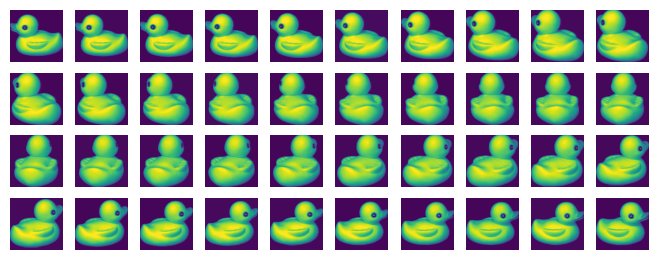

In [4]:
fig, axs = plt.subplots(ncols=10, nrows=4)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(data['obj1'][i])
    ax.axis('off')
# lower remove margins
fig.subplots_adjust(left=0, right=1, top=1, bottom=0.5)

In [9]:
dataset = GmGM.Dataset(
    dataset={'obj1': data['obj1']},
    structure={
        object: (f'frame', f'{object}_row', f'{object}_column')
        for object in headers
        if object == 'obj1'
    },
    batch_axes=None
)

In [28]:
results = GmGM.GmGM(
    dataset,
    to_keep=0.5,
    threshold_method="bonferroni",
    n_comps=None,
    verbose=True,
    centering_method=None,
    use_nonparanormal_skeptic=True,
    nonparanormal_evec_backend="COCA",
    readonly=False,
    calculate_explained_variance=True,
    batch_size=1000
)
results

Centering...
Calculating eigenvectors...
	by calculating gram matrices and then eigendecomposing...
Calculating eigenvectors for axis='frame'
Calculating eigenvectors for axis='obj1_column'
Calculating eigenvectors for axis='obj1_row'
100% explained variance, since `n_comps` was not specified
Calculating eigenvalues...
@0: -3730197.7970885113 (-3730228.1112386812 + 30.314150170185354 + 0) ∆inf


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/GmGM/GmGM.py:229: UserWarning: This is outdated, will swap to using direct_left_eigenvectors in the future
  warnings.warn("This is outdated, will swap to using direct_left_eigenvectors in the future")


Converged! (@42: -5044347.9378312705)
Recomposing sparse precisions...
Done!


Dataset(
	obj1: ('frame', 'obj1_row', 'obj1_column')
)
Axes(
	frame: 72
		Prior: None
		Gram: Calculated
		Eig: Calculated
	obj1_column: 128
		Prior: None
		Gram: Calculated
		Eig: Calculated
	obj1_row: 128
		Prior: None
		Gram: Calculated
		Eig: Calculated
)

In [30]:
(results.precision_matrices['frame'].toarray())

array([[43.39269   ,  0.19916064,  0.        , ...,  0.19996485,
         0.20129912,  0.20274436],
       [ 0.19916064, 43.39597   ,  0.        , ...,  0.19644079,
         0.19778249,  0.19931151],
       [ 0.        ,  0.        , 43.40446   , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.19996485,  0.19644079,  0.        , ..., 43.38584   ,
         0.20658885,  0.20446281],
       [ 0.20129912,  0.19778249,  0.        , ...,  0.20658885,
        43.38756   ,  0.20560682],
       [ 0.20274436,  0.19931151,  0.        , ...,  0.20446281,
         0.20560682, 43.38784   ]], dtype=float32)

Text(0.5, 1.0, 'Frames graph')

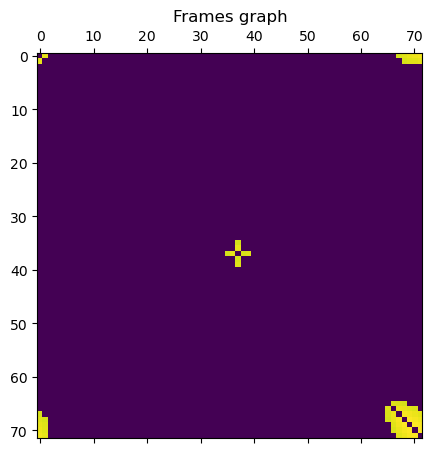

In [38]:
# Create a random graph
frames_res = results.precision_matrices['frame'].toarray()
np.fill_diagonal(frames_res, 0)

fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))
ax1.matshow(frames_res)
ax1.set_title("Frames graph")

# for (i, j), z in np.ndenumerate(frames_res):
#     ax1.text(
#         j,
#         i,
#         '{:0.1f}'.format(z),
#         ha='center',
#         va='center',
#         bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3')
#     )